<a href="https://colab.research.google.com/github/malinianbalagan/powerbi-prj/blob/main/Skin_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Step 0: Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- Step 1: Extract Dataset ---
import zipfile, os
zip_path = "/content/drive/MyDrive/Skin Disease Dataset.zip"  # Change path if needed
extract_path = "/content/skin_cancer_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted to:", extract_path)
print("📂 Folders inside extracted path:", os.listdir(extract_path))

✅ Dataset extracted to: /content/skin_cancer_data
📂 Folders inside extracted path: ['data', 'test', 'train']


In [ ]:
import os

train_path = "/content/skin_cancer_data/data/test"
test_path = "/content/skin_cancer_data/data/train"

print("Train folders:", os.listdir(train_path))
print("Test folders:", os.listdir(test_path))


Train folders: ['malignant', 'benign']
Test folders: ['malignant', 'benign']


In [ ]:
# --- Step 2: Import Libraries ---
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from tensorflow.keras.preprocessing import image
import pandas as pd
from IPython.display import display
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
# --- Step 3: Prepare Data ---
test_dir = '/content/skin_cancer_data/data/test'
train_dir  = '/content/skin_cancer_data/data/train'


# --- Data Augmentation for train & validation ---
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,  # 20% for validation
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

# --- Test generator ---
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)



Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [ ]:
import os

print("Train folders:", os.listdir("/content/skin_cancer_data/train"))
print("Validation is subset of train (20%)")
print("Test folders:", os.listdir("/content/skin_cancer_data/test"))


Train folders: ['malignant', 'benign']
Validation is subset of train (20%)
Test folders: ['malignant', 'benign']


In [ ]:
# --- Step 5: Build EfficientNetB0 Model ---
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base for initial training

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- Step 6: Callbacks ---
es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
mc = ModelCheckpoint("best_skin_model.keras", monitor='val_accuracy', save_best_only=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# --- Step 7: Train Top Layers ---
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[es, rlr, mc]
)

# --- Step 8: Fine-tune Last Layers ---
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False  # keep most layers frozen

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[es, rlr, mc]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.7242 - loss: 0.5241 - val_accuracy: 0.8140 - val_loss: 0.4268 - learning_rate: 0.0010
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.8341 - loss: 0.3897 - val_accuracy: 0.7742 - val_loss: 0.4402 - learning_rate: 0.0010
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.8278 - loss: 0.3700 - val_accuracy: 0.8216 - val_loss: 0.3936 - learning_rate: 0.0010
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.8339 - loss: 0.3424 - val_accuracy: 0.8216 - val_loss: 0.3911 - learning_rate: 0.0010
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.8559 - loss: 0.3080 - val_accuracy: 0.8330 - val_loss: 0.3656 - learning_rate: 0.0010
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.8455 - loss: 0.3112 - val_accuracy: 0.7989 - val_loss: 0.4093 - learning_rate: 0.0010
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.8600 - loss: 0.

In [ ]:
# --- Step 9: Evaluate on Test Set ---
test_loss, test_acc = model.evaluate(test_gen)
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
auc_score = roc_auc_score(y_true, y_pred_probs)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test AUC-ROC: {auc_score:.3f}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 981ms/step - accuracy: 0.8534 - loss: 0.2994
42/42 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step

Test Accuracy: 78.48%
Test AUC-ROC: 0.904


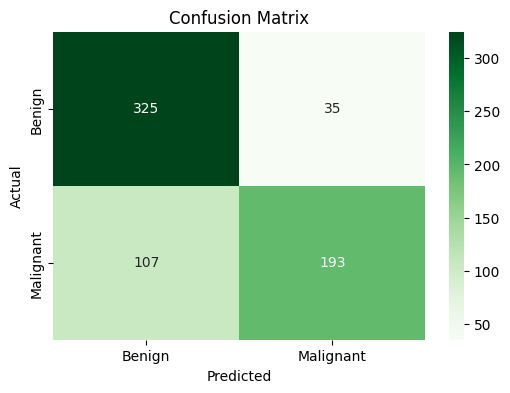

In [ ]:
# --- Step 10: Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Benign','Malignant'], yticklabels=['Benign','Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# --- Step 11: Classification Report ---
print(classification_report(y_true, y_pred, target_names=['Benign','Malignant']))

              precision    recall  f1-score   support

      Benign       0.75      0.90      0.82       360
   Malignant       0.85      0.64      0.73       300

    accuracy                           0.78       660
   macro avg       0.80      0.77      0.78       660
weighted avg       0.80      0.78      0.78       660



In [ ]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']


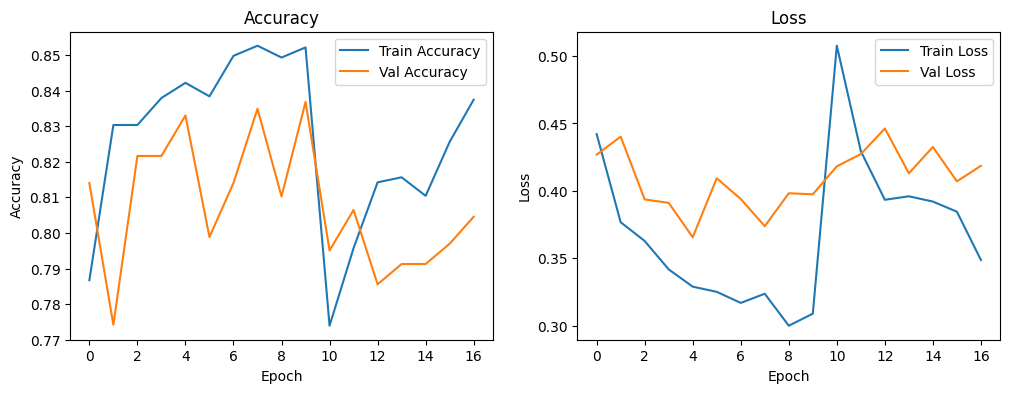

In [ ]:
# --- Step 12: Plot Accuracy & Loss ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

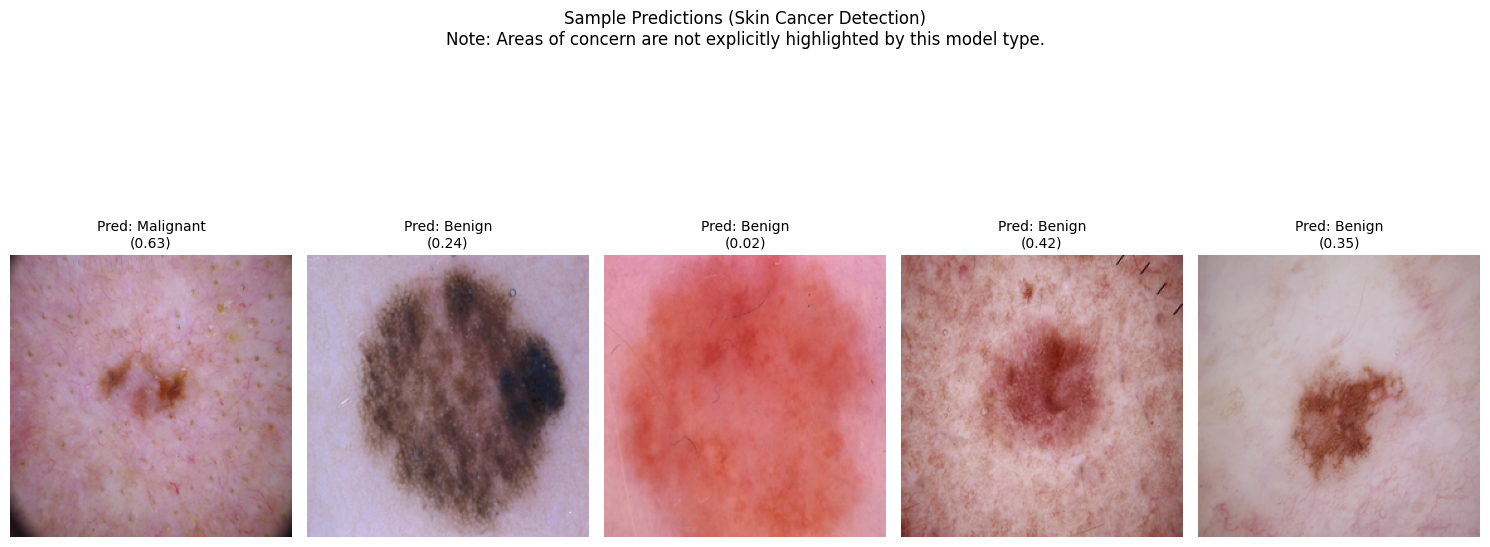

In [ ]:
from tensorflow.keras.preprocessing import image
import random
import matplotlib.pyplot as plt
import numpy as np

# Get random sample of validation images
image_files = val_gen.filepaths
sample_images = random.sample(image_files, 5)

plt.figure(figsize=(15,8))

for i, img_path in enumerate(sample_images):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # EfficientNet preprocessing

    # Make prediction
    pred_prob = model.predict(img_array, verbose=0)[0][0]
    label = "Malignant" if pred_prob > 0.5 else "Benign"

    # Plot image with prediction
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.title(f"Pred: {label}\n({pred_prob:.2f})", fontsize=10)
    plt.axis('off')

plt.suptitle(
    "Sample Predictions (Skin Cancer Detection)\n"
    "Note: Areas of concern are not explicitly highlighted by this model type.",
    y=0.95,
    fontsize=12
)
plt.tight_layout()
plt.show()


In [ ]:
# --- Step 13: Display Summary & Classification Report ---
import pandas as pd
from IPython.display import display, Markdown

# Training & validation counts
train_count = train_gen.samples
val_count = val_gen.samples
final_val_acc = history_fine.history['val_accuracy'][-1] if history_fine else history.history['val_accuracy'][-1]

print("### Model Training & Final Accuracy")
data_summary = {
    "Metric": ["Training Set Images", "Validation/Test Set Images", "Final Validation Accuracy"],
    "Value": [train_count, val_count, f"{final_val_acc:.4f} ({final_val_acc*100:.2f}%)"]
}
df_summary = pd.DataFrame(data_summary)
display(df_summary.style.hide(axis='index').set_properties(**{'text-align':'center'}))

print("\n" + "="*50 + "\n")




### Model Training & Final Accuracy


Metric,Value
Training Set Images,2110
Validation/Test Set Images,527
Final Validation Accuracy,0.8046 (80.46%)




42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 980ms/step
### Detailed Classification Report


,precision,recall,f1-score,support
Benign,0.75,0.90,0.82,360
Malignant,0.85,0.64,0.73,300
accuracy,0.78,0.78,0.78,0
macro avg,0.80,0.77,0.78,660
weighted avg,0.80,0.78,0.78,660
